In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.8.3/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetB_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetB_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [20]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [21]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP(hPa)": SLP, "Sfc Winds(m/s)": Windspeed, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [22]:
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [23]:
# Find Precip Rate From Compo File
def Precip(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [24]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP(hPa)"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((2,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    return (DF_Storm_Compo)

In [25]:
# Create Function to Find Compo Info
def Find_Compo_Info(Code, Data_DF, ET_DF, Compo_DF, Compo_nc):
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
    DF_Storm_Compo = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Seperate Into Tropical, Transitioning, and Extratropical Portions
    DF_Storm_Compo_TC = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Tropical"]
    DF_Storm_Compo_Trans = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Transition"].reset_index()
    DF_Storm_Compo_ExTC = DF_Storm_Compo[DF_Storm_Compo["Storm Phase"] == "Extratropical"].reset_index()
# Find Compo Index of Storm Peak
    if len(DF_Storm_Compo_ExTC) > 0:
        Max_Wind_850 = numpy.max(numpy.array(DF_Storm_Compo_TC["850hPa Winds"]))
        Storm_Peak_Index = DF_Storm_Compo_TC[DF_Storm_Compo_TC["850hPa Winds"] >= Max_Wind_850].reset_index()["Compo Index"][0]
# Find Compo Index of ET Begin
        if len(DF_Storm_Compo_Trans) > 0:
            ET_Begin_Index = DF_Storm_Compo_Trans["Compo Index"][0]
        else:
            ET_Begin_Index = DF_Storm_Compo_ExTC["Compo Index"][0]
# Find Compo Index of ET Complete
        ET_Compl_Index = DF_Storm_Compo_ExTC["Compo Index"][0]
        Time_Indexes = [Storm_Peak_Index, ET_Begin_Index, ET_Compl_Index]
#
# If Incomplete Data
    else:
        print ("NAN", Code)
        Time_Indexes = [numpy.nan, numpy.nan, numpy.nan]
    return (Time_Indexes)

In [26]:
# Create Function to Combine Windspeed Maps
def Wind_Snaps_Combine(Subset_Codes, Data_DF, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C, Mean):
    Wind_Snap_All = numpy.zeros((len(Subset_Codes),3,80,80))
    for n in range(len(Subset_Codes)):
        Code = Subset_Codes[n]
        ABC = ET_DF[ET_DF["Code"] == Code].reset_index()["ABC"][0]
        if ABC == "A":
            Compo_nc = Compo_nc_A
        elif ABC == "B":
            Compo_nc = Compo_nc_B
        elif ABC == "C":
            Compo_nc = Compo_nc_C
        Time_Indexes = Find_Compo_Info(Code, Data_DF, ET_DF, Compo_DF, Compo_nc)
        for t in range(len(Time_Indexes)):
            try:
                Windspeed_Snap = Windspeed_850hPa(Compo_nc, Time_Indexes[t])
                Wind_Snap_All[n][t] = Windspeed_Snap
            except:
                Wind_Snap_All[n][t] = numpy.nan
    if Mean == True:
        Wind_Snap_Mean = numpy.nanmean(Wind_Snap_All, axis=0)
        return (Wind_Snap_Mean)
    else:
        Wind_Snap_Median = numpy.nanmedian(Wind_Snap_All, axis=0)
        return (Wind_Snap_Median)

In [27]:
# Create Function to Combine Precip Maps
def Precip_Snaps_Combine(Subset_Codes, Data_DF, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C, Mean):
    Precip_Snap_All = numpy.zeros((len(Subset_Codes),3,80,80))
    for n in range(len(Subset_Codes)):
        Code = Subset_Codes[n]
        ABC = ET_DF[ET_DF["Code"] == Code].reset_index()["ABC"][0]
        if ABC == "A":
            Compo_nc = Compo_nc_A
        elif ABC == "B":
            Compo_nc = Compo_nc_B
        elif ABC == "C":
            Compo_nc = Compo_nc_C
        Time_Indexes = Find_Compo_Info(Code, Data_DF, ET_DF, Compo_DF, Compo_nc)
        for t in range(len(Time_Indexes)):
            try:
                Precip_Snap = Precip(Compo_nc, Time_Indexes[t])
                Precip_Snap_All[n][t] = Precip_Snap
            except:
                Precip_Snap_All[n][t] = numpy.nan
    if Mean == True:
        Precip_Snap_Mean = numpy.nanmean(Precip_Snap_All, axis=0)
        return (Precip_Snap_Mean)
    else:
        Precip_Snap_Median = numpy.nanmedian(Precip_Snap_All, axis=0)
        return (Precip_Snap_Median)

In [28]:
# Create Subsets of Dataframe Based on Selection Criteria

In [29]:
#Control_Subset = Control_ET[Control_ET['Code'].isin(Control_Codes)]
Control_Subset_Codes = list(Control_ET['Code'])
Control_ET

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Peak SLP,Peak Lon,Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat
0,TC190003,Colin,A,1,1900-09-18 00:00:00,1900-09-20 12:00:00,1900-09-19 12:00:00,934.83,-70.67,39.42,952.06,-77.17,31.14,979.68,-62.68,47.61
1,TC190004,Dawn,A,1,1900-11-05 12:00:00,1900-11-06 12:00:00,1900-11-04 00:00:00,948.88,-91.58,20.70,954.74,-87.08,27.00,992.74,-74.44,30.88
2,TC190105,Lydia,A,1,1901-09-27 12:00:00,1901-09-29 18:00:00,1901-09-24 00:00:00,913.33,-60.97,29.81,953.76,-53.37,39.19,970.00,-42.82,48.53
3,TC190106,Mario,A,1,1901-09-22 00:00:00,1901-09-22 18:00:00,1901-09-22 12:00:00,988.80,-74.39,39.50,993.69,-78.47,35.78,991.98,-71.20,41.68
4,TC190109,Song,A,1,1901-12-14 00:00:00,1901-12-14 06:00:00,1901-12-11 06:00:00,942.03,-48.79,45.54,975.20,-32.75,47.00,975.97,-30.25,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,TC198704,Inaki,C,3,1987-09-13 12:00:00,1987-09-13 12:00:00,1987-09-14 18:00:00,986.42,-54.75,51.75,1000.18,-69.62,41.87,1000.18,-69.62,41.87
178,TC198802,Micah,C,1,1988-02-06 00:00:00,1988-02-06 06:00:00,1988-02-05 06:00:00,998.09,-35.19,36.46,999.63,-31.01,38.29,999.02,-28.74,38.72
179,TC198805,Seldoen,C,1,1988-09-07 06:00:00,1988-09-08 12:00:00,1988-09-07 00:00:00,980.43,-49.24,32.21,984.68,-48.37,33.35,987.91,-35.17,42.45
180,TC198809,Bruce,C,1,1988-09-21 06:00:00,1988-09-27 00:00:00,1988-09-22 00:00:00,934.40,-63.31,32.34,961.07,-66.39,30.40,1001.36,-41.00,47.00


In [30]:
#RCP45_Subset = RCP45_ET[RCP45_ET['Code'].isin(RCP45_Codes)]
RCP45_Subset_Codes = list(RCP45_ET['Code'])
RCP45_ET

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Peak SLP,Peak Lon,Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat
0,TC200004,Dawn,A,2,2000-03-16 18:00:00,2000-03-18 00:00:00,2000-03-14 12:00:00,974.18,-58.07,41.52,995.91,-55.46,51.57,984.01,-45.95,51.83
1,TC200302,Katrina,A,1,2003-03-04 00:00:00,2003-03-05 18:00:00,2003-03-04 06:00:00,978.85,-31.83,51.27,981.00,-32.57,49.83,996.69,-33.75,47.00
2,TC200403,Andy,A,1,2004-05-08 18:00:00,2004-05-10 12:00:00,2004-05-07 18:00:00,978.81,-48.82,33.18,979.32,-42.93,35.03,986.81,-32.03,47.16
3,TC200503,Lily,A,1,2005-06-09 12:00:00,2005-06-11 00:00:00,2005-06-09 18:00:00,973.25,-74.52,35.84,979.25,-77.06,33.41,1000.72,-61.75,44.25
4,TC200510,Anna,A,1,2005-09-09 12:00:00,2005-09-11 06:00:00,2005-09-07 00:00:00,897.70,-60.07,23.57,933.51,-60.82,37.35,959.00,-43.52,47.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,TC209004,Emmelyn,C,2,2090-04-28 00:00:00,2090-04-28 06:00:00,2090-04-25 06:00:00,988.22,-26.93,39.99,999.88,-23.70,35.16,1001.37,-21.58,35.21
104,TC209010,Mary,C,2,2090-10-17 00:00:00,2090-10-17 06:00:00,2090-10-18 00:00:00,969.47,-49.80,46.04,989.48,-66.46,35.11,986.06,-62.92,36.33
105,TC209011,Nabil,C,1,2090-11-06 00:00:00,2090-11-09 12:00:00,2090-11-08 18:00:00,962.96,-30.03,50.08,994.31,-55.40,37.56,970.20,-20.27,49.55
106,TC209101,Rosalina,C,1,2091-01-14 00:00:00,2091-01-15 12:00:00,2091-01-15 06:00:00,963.38,-43.48,47.31,978.54,-56.81,31.00,968.11,-41.18,49.59


In [31]:
#RCP85_Subset = RCP85_ET[RCP85_ET['Code'].isin(RCP85_Codes)]
RCP85_Subset_Codes = list(RCP85_ET['Code'])
RCP85_ET

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Peak SLP,Peak Lon,Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat
0,TC210003,Colin,A,2,2100-03-03 18:00:00,2100-03-04 00:00:00,2100-03-01 12:00:00,943.01,-45.04,45.78,970.11,-32.30,41.93,971.02,-29.14,42.38
1,TC210005,Ernest,A,2,2100-09-01 06:00:00,2100-09-01 12:00:00,2100-08-28 12:00:00,968.16,-79.09,29.45,1003.30,-76.85,39.42,1001.84,-74.73,41.55
2,TC210103,Lydia,A,1,2101-07-26 12:00:00,2101-07-28 00:00:00,2101-07-26 18:00:00,971.18,-50.38,41.08,971.89,-53.14,39.28,992.45,-37.66,46.61
3,TC210105,Nicole,A,1,2101-09-12 18:00:00,2101-09-14 18:00:00,2101-09-08 18:00:00,902.97,-57.85,23.01,934.13,-60.07,35.72,962.56,-47.38,49.02
4,TC210106,Phil,A,1,2101-09-22 18:00:00,2101-09-23 18:00:00,2101-09-21 00:00:00,987.95,-57.90,27.28,997.21,-55.88,36.75,1001.49,-44.60,45.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,TC219001,James,C,2,2190-02-14 06:00:00,2190-02-14 18:00:00,2190-02-13 06:00:00,979.77,-32.91,35.03,986.02,-31.87,31.67,990.20,-26.99,30.76
132,TC219002,Katie,C,1,2190-09-03 12:00:00,2190-09-06 00:00:00,2190-09-04 18:00:00,935.09,-60.45,39.01,942.40,-70.89,33.19,939.94,-42.18,50.54
133,TC219008,Toby,C,1,2190-11-17 06:00:00,2190-11-18 12:00:00,2190-11-13 06:00:00,945.86,-57.77,33.12,978.43,-56.90,37.77,967.20,-29.04,51.12
134,TC219102,Alex,C,1,2191-09-09 12:00:00,2191-09-11 00:00:00,2191-09-09 18:00:00,920.35,-56.99,42.19,926.25,-59.21,40.19,984.72,-40.68,50.61


In [32]:
# Define Colours and Bounds
Windspeed_Colours = ['white', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
Precip_Colours = ['white', 'cyan', 'deepskyblue', 'dodgerblue', 'lightseagreen', 'limegreen', 'greenyellow', \
'gold', 'darkorange']
Precip_Bounds = numpy.array([0.1,0.5,1,2,5,10,20,30])

In [33]:
# Create Function to Plot Contour Maps
def Contour_Map(Axis, i, j, Snap, x_Snap, y_Snap, Bounds, Colours, Model, Time_Label, Var):
# Add Corrdinate Lines
    Axis.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    Axis.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Initial Indexes
#    i_Init = 0
#    j_Init = 0
#    i_Fin = 80
#    j_Fin = 80
# Plot Contour Map
    Axis.contourf(x_Snap, y_Snap, Snap, levels=Bounds, colors=Colours, extend='both')
# Formatting
#    x_Min = float(x_Snap[i_Init])
#    x_Max = float(x_Snap[i_Fin-1])
#    y_Min = float(y_Snap[j_Init])
#    y_Max = float(y_Snap[j_Fin-1])
    if Var == "Wind":
        Axis.set_xlim(-8,8)
        Axis.set_ylim(-8,8)
        Axis.set_xticks(Create_Bins(-8,8,2))
        Axis.set_yticks(Create_Bins(-8,8,2))
    elif Var == "Precip":
        Axis.set_xlim(-5,5)
        Axis.set_ylim(-5,5)
        Axis.set_xticks(Create_Bins(-5,5,1))
        Axis.set_yticks(Create_Bins(-5,5,1))
    if i == 2:
        Axis.set_xlabel('Lon Diff From Storm Center', fontsize=12)
    if j == 0:
        Axis.set_ylabel('Lat Diff From Storm Center', fontsize=12)
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Model + ' -- ' + Var + ' Field at ' + Time_Label)
    Axis.set_title(Title, fontsize=18)

In [34]:
# Plot Windspeed Snap Plots
def Windspeed_Snap_Plots(Models_Wind_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Var = "Wind"
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for i in range(3):
        for j in range(3):
            Contour_Map(Axes[i][j], i, j, Models_Wind_Snaps[i][j], x_Snap, y_Snap, Bounds, Colours, \
            Models[i], Time_Labels[j], Var)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeed", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeed (m/s)', shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [35]:
# Plot Precip Snap Plots
def Precip_Snap_Plots(Models_Precip_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Var = "Precip"
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for i in range(3):
        for j in range(3):
            Contour_Map(Axes[i][j], i, j, Models_Precip_Snaps[i][j], x_Snap, y_Snap, Bounds, Colours, \
            Models[i], Time_Labels[j], Var)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Precip Rate", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='Precip Rate (mm/hr)', shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [36]:
Find_Composite_Data("TC202006", RCP45_Data, RCP45_Compo)

,Compo Index,Time,Lon,Lat,SLP(hPa),Sfc Winds(m/s),Storm Phase
0,4619.0,2020-08-10 12:00:00,-32.43,17.00,1009.93,12.2,Tropical
1,4620.0,2020-08-10 18:00:00,-33.72,16.70,1007.71,14.4,Tropical
2,4621.0,2020-08-11 00:00:00,-34.29,17.04,1008.61,19.4,Tropical
3,4622.0,2020-08-11 06:00:00,-36.03,17.92,1008.40,20.1,Tropical
4,4623.0,2020-08-11 12:00:00,-38.00,18.71,1010.18,18.2,Tropical
5,4624.0,2020-08-11 18:00:00,-40.21,19.41,1010.17,18.6,Tropical
6,4625.0,2020-08-12 00:00:00,-42.70,19.77,1011.00,20.0,Tropical
7,4626.0,2020-08-12 06:00:00,-45.39,20.47,1006.55,23.2,Tropical
8,4627.0,2020-08-12 12:00:00,-47.81,20.83,1005.31,29.6,Tropical
9,4628.0,2020-08-12 18:00:00,-50.31,20.98,1004.90,24.7,Tropical


In [37]:
# Calculate Mean Windspeed Snapshots
Control_Wind_Snap_Mean = Wind_Snaps_Combine(Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, True)
RCP45_Wind_Snap_Mean = Wind_Snaps_Combine(RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, True)
RCP85_Wind_Snap_Mean = Wind_Snaps_Combine(RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, True)
#Control_Wind_Snap_Mean

NAN TC215006
NAN TC216407


In [38]:
# Calculate Mean Precip Snapshots
Control_Precip_Snap_Mean = Precip_Snaps_Combine(Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, True)
RCP45_Precip_Snap_Mean = Precip_Snaps_Combine(RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, True)
RCP85_Precip_Snap_Mean = Precip_Snaps_Combine(RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, True)
#Control_Precip_Snap_Mean

NAN TC215006
NAN TC216407


In [39]:
# Calculate Median Windspeed Snapshots
Control_Wind_Snap_Median = Wind_Snaps_Combine(Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, False)
RCP45_Wind_Snap_Median = Wind_Snaps_Combine(RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, False)
RCP85_Wind_Snap_Median = Wind_Snaps_Combine(RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, False)
#Control_Wind_Snap_Median

NAN TC215006
NAN TC216407


In [40]:
# Calculate Median Precip Snapshots
Control_Precip_Snap_Median = Precip_Snaps_Combine(Control_Subset_Codes, Control_Data, Control_ET, \
Control_Compo, Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc, False)
RCP45_Precip_Snap_Median = Precip_Snaps_Combine(RCP45_Subset_Codes, RCP45_Data, RCP45_ET, \
RCP45_Compo, RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc, False)
RCP85_Precip_Snap_Median = Precip_Snaps_Combine(RCP85_Subset_Codes, RCP85_Data, RCP85_ET, \
RCP85_Compo, RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc, False)
#Control_Precip_Snap_Median

NAN TC215006
NAN TC216407


In [41]:
# Mean Snapshot Plots

In [42]:
Time_Labels = ["Storm Peak", "ET Begin", "ET Complete"]

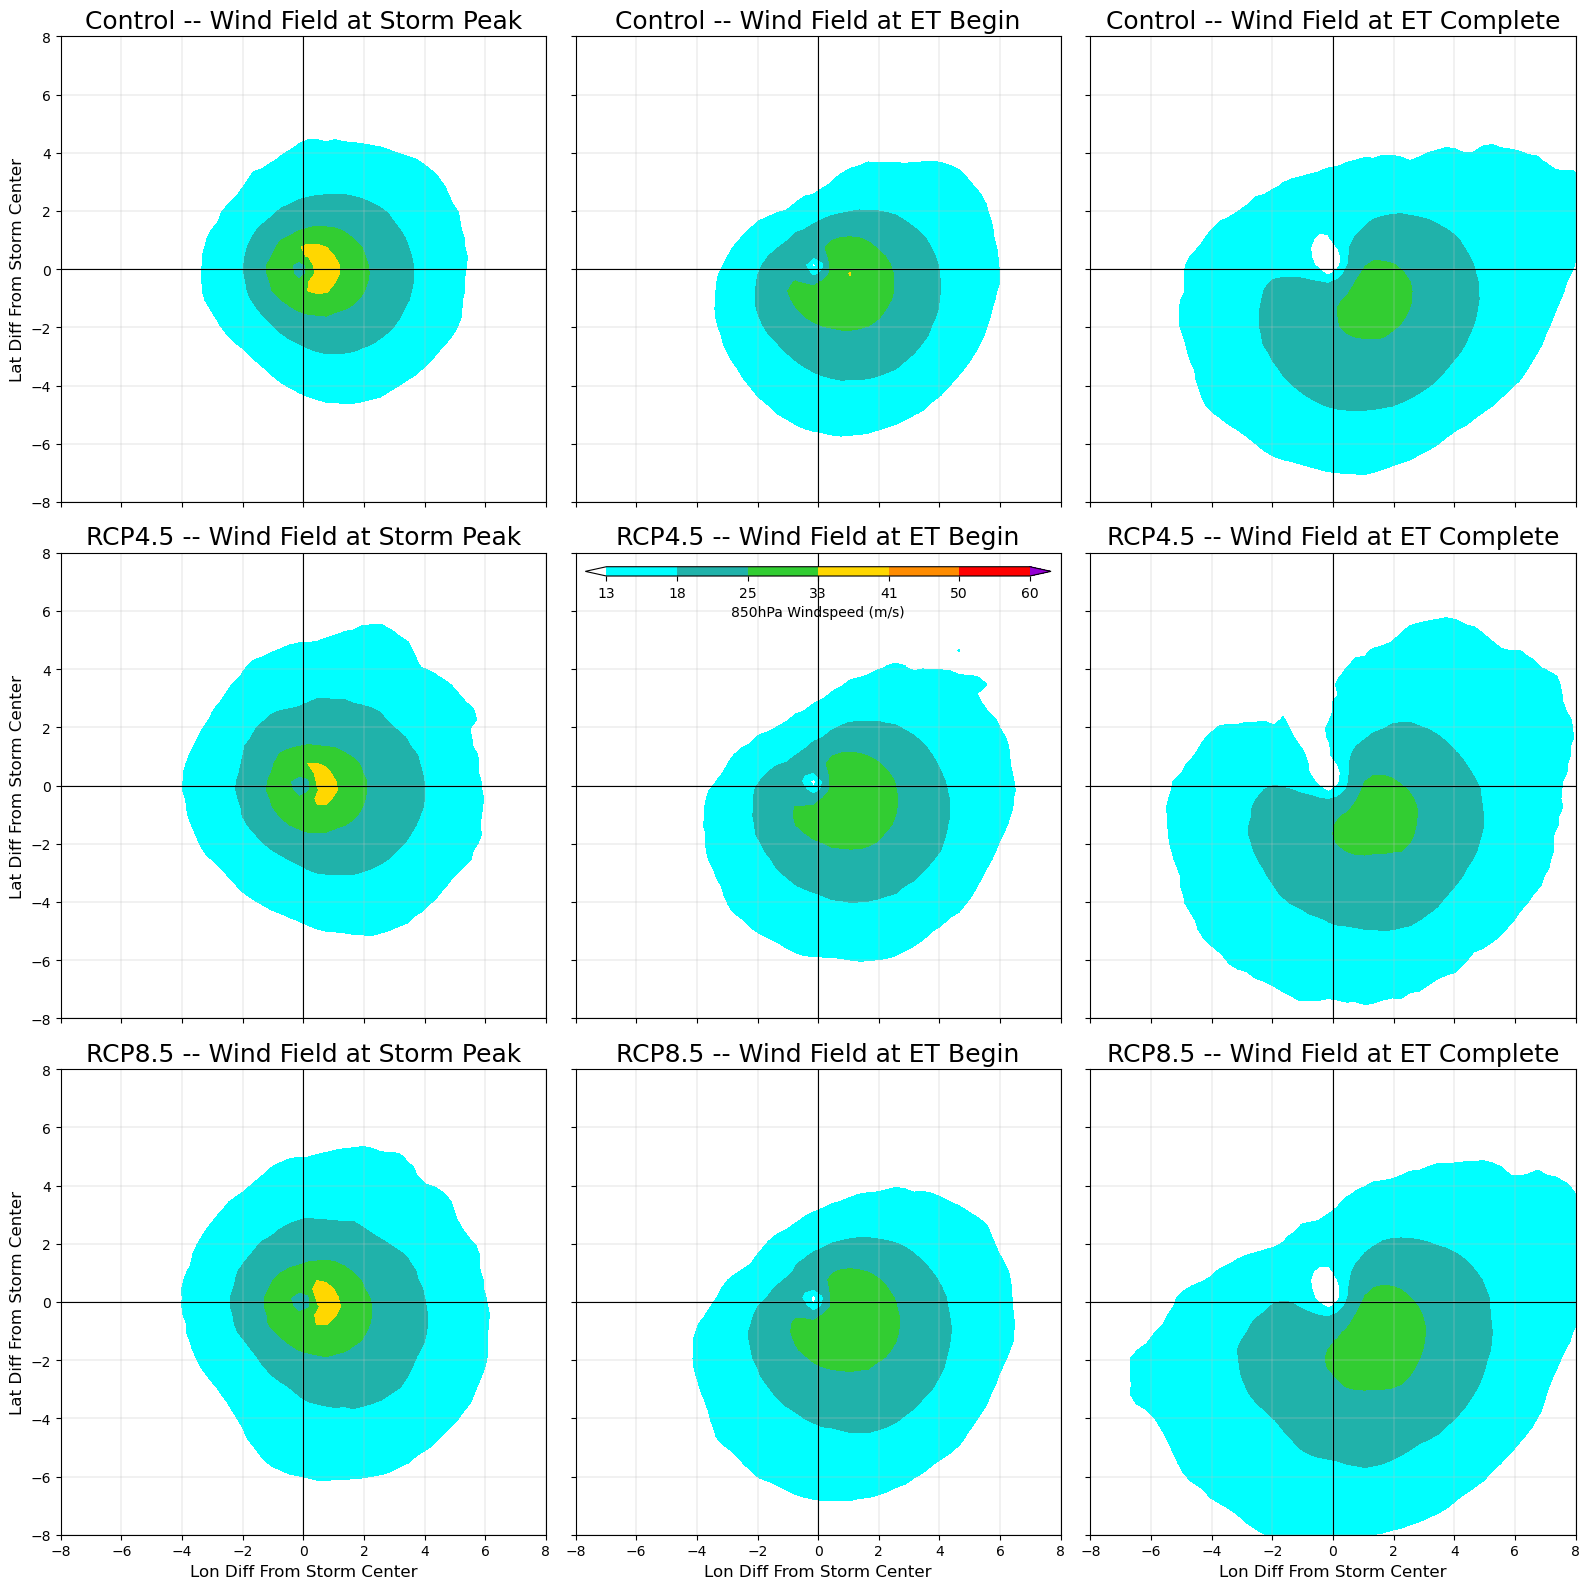

In [43]:
Windspeed_Snap_Plots([Control_Wind_Snap_Mean, RCP45_Wind_Snap_Mean, RCP85_Wind_Snap_Mean], \
Control_A_Compo_nc, Time_Labels, Windspeed_Bounds, Windspeed_Colours, True, 'Wind_Snaps_Mean.png')

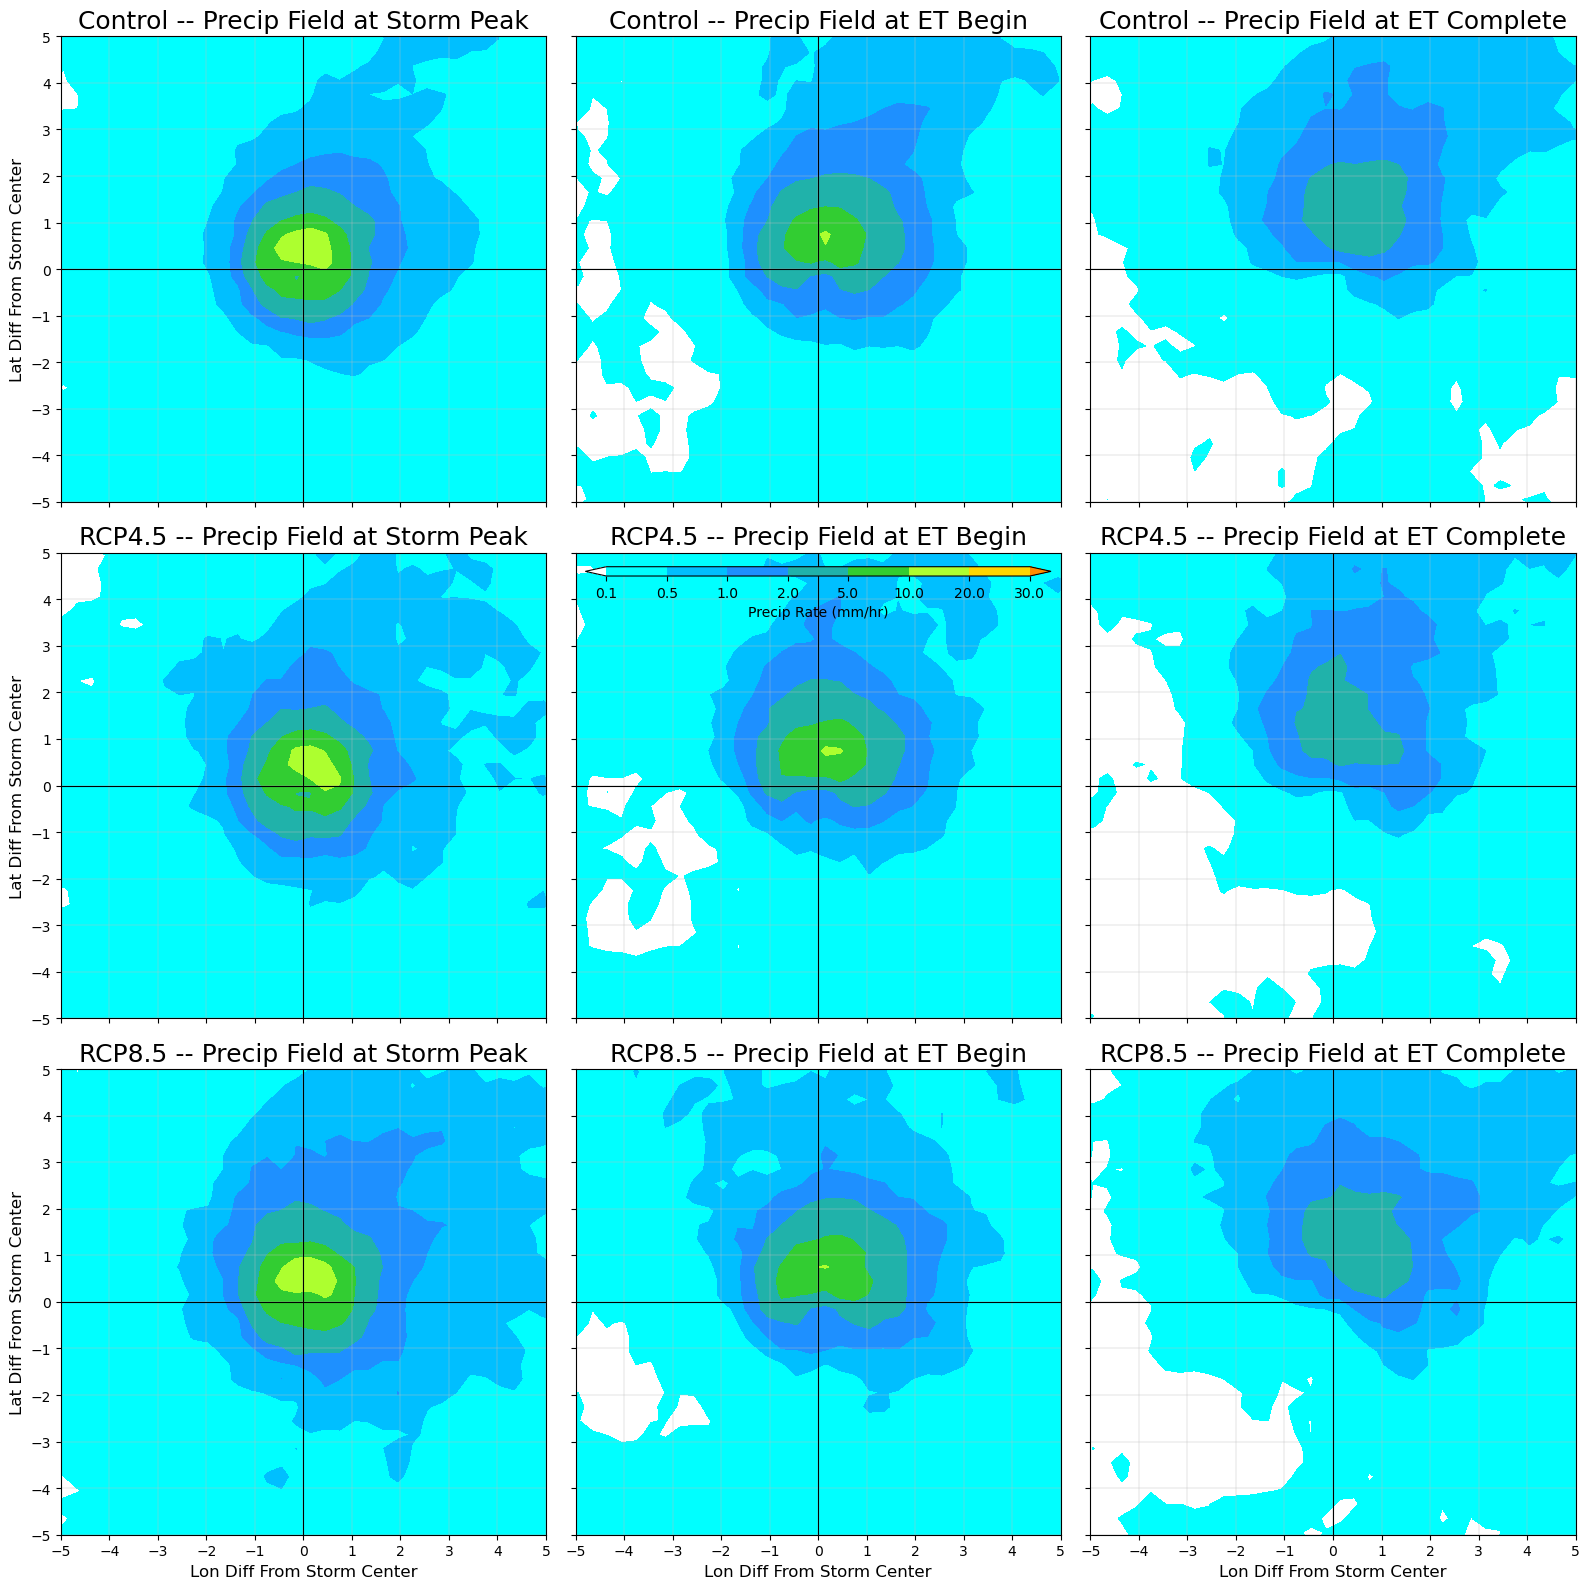

In [44]:
Precip_Snap_Plots([Control_Precip_Snap_Mean, RCP45_Precip_Snap_Mean, RCP85_Precip_Snap_Mean], \
Control_A_Compo_nc, Time_Labels, Precip_Bounds, Precip_Colours, True, 'Precip_Snaps_Mean.png')

In [45]:
# Median Snapshot Plots

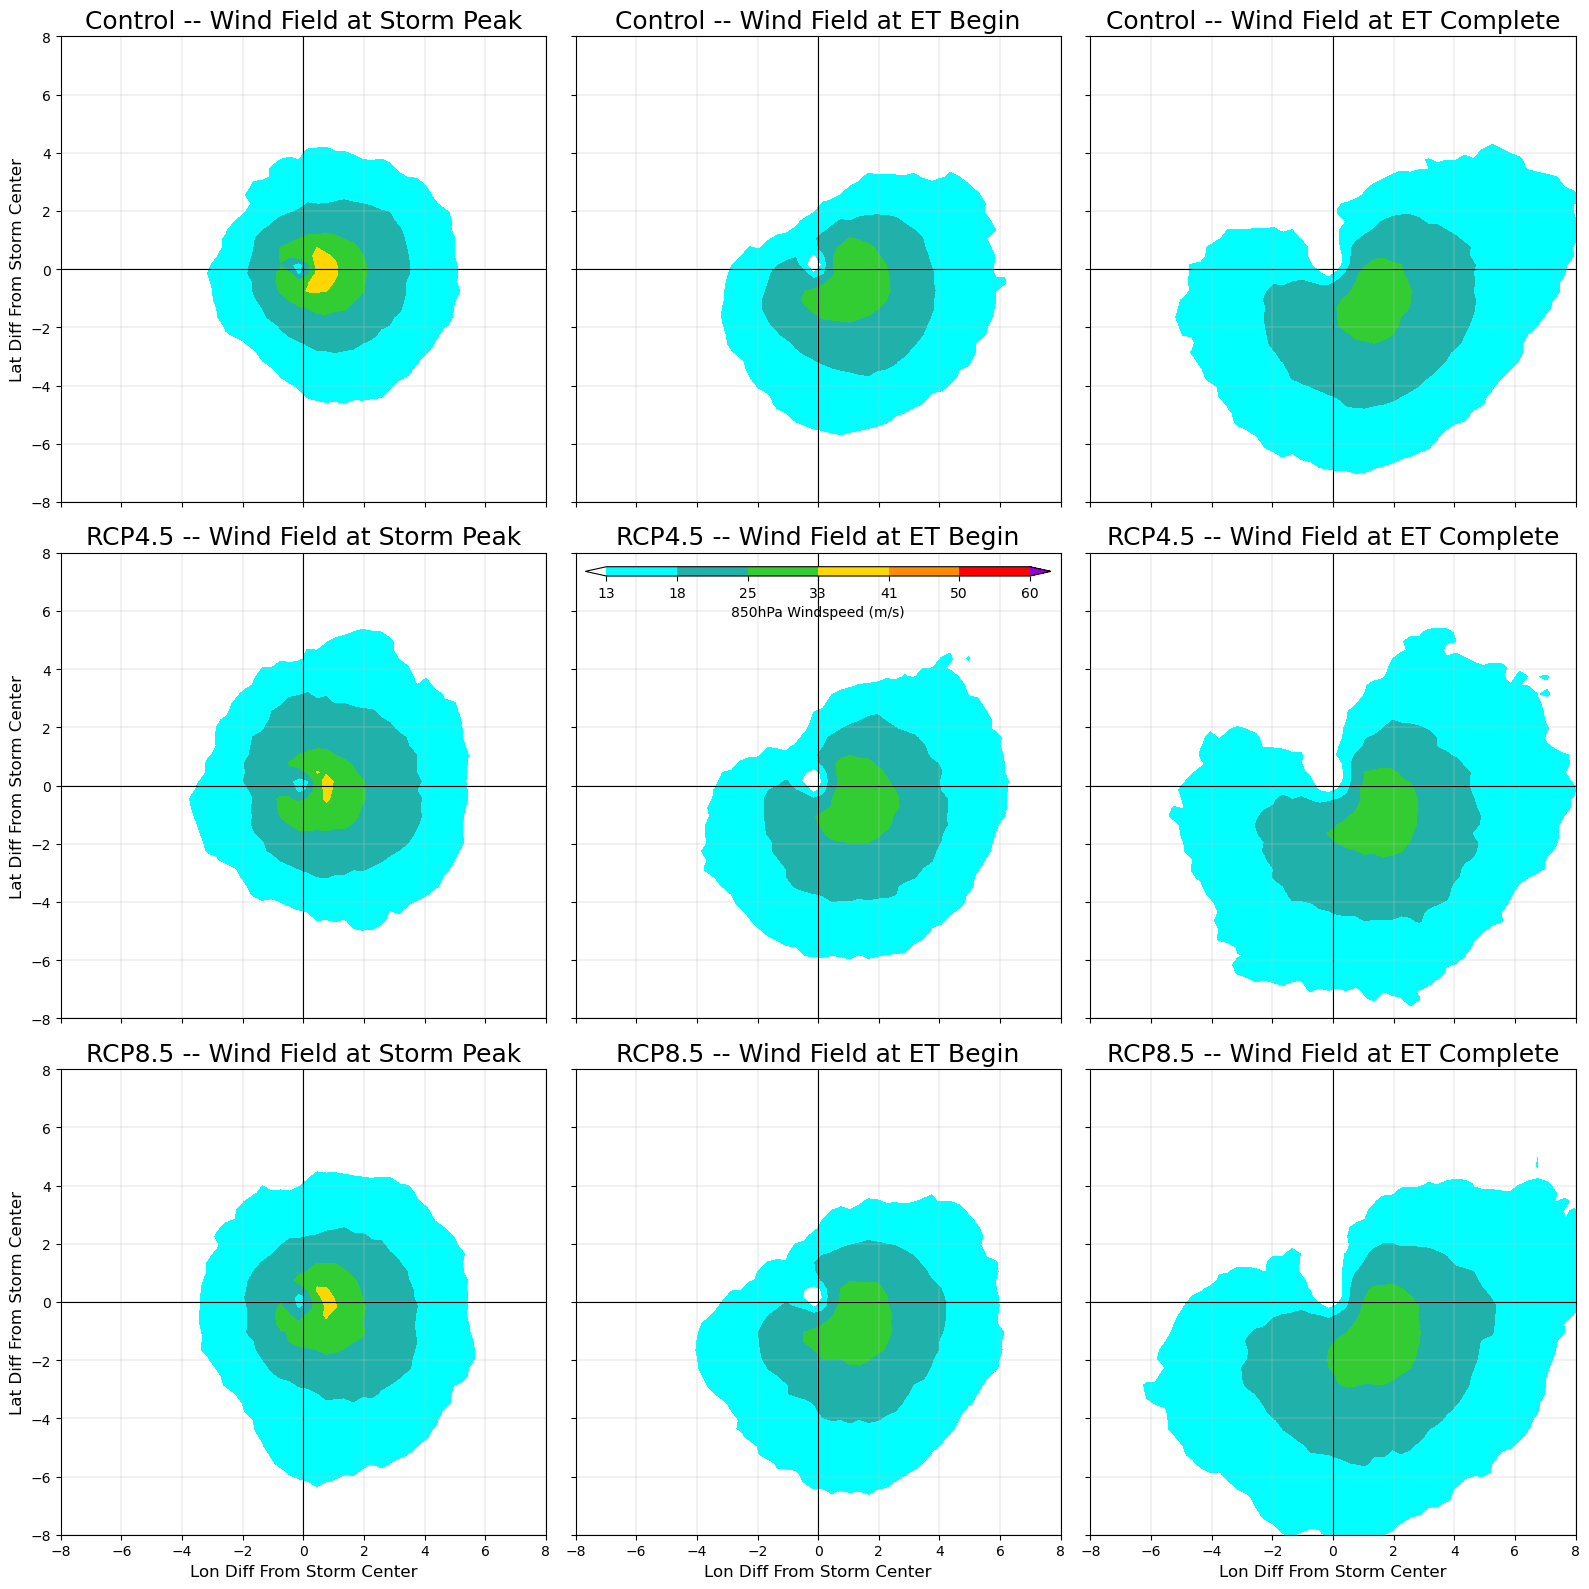

In [46]:
Windspeed_Snap_Plots([Control_Wind_Snap_Median, RCP45_Wind_Snap_Median, RCP85_Wind_Snap_Median], \
Control_A_Compo_nc, Time_Labels, Windspeed_Bounds, Windspeed_Colours, True, 'Wind_Snaps_Median.png')

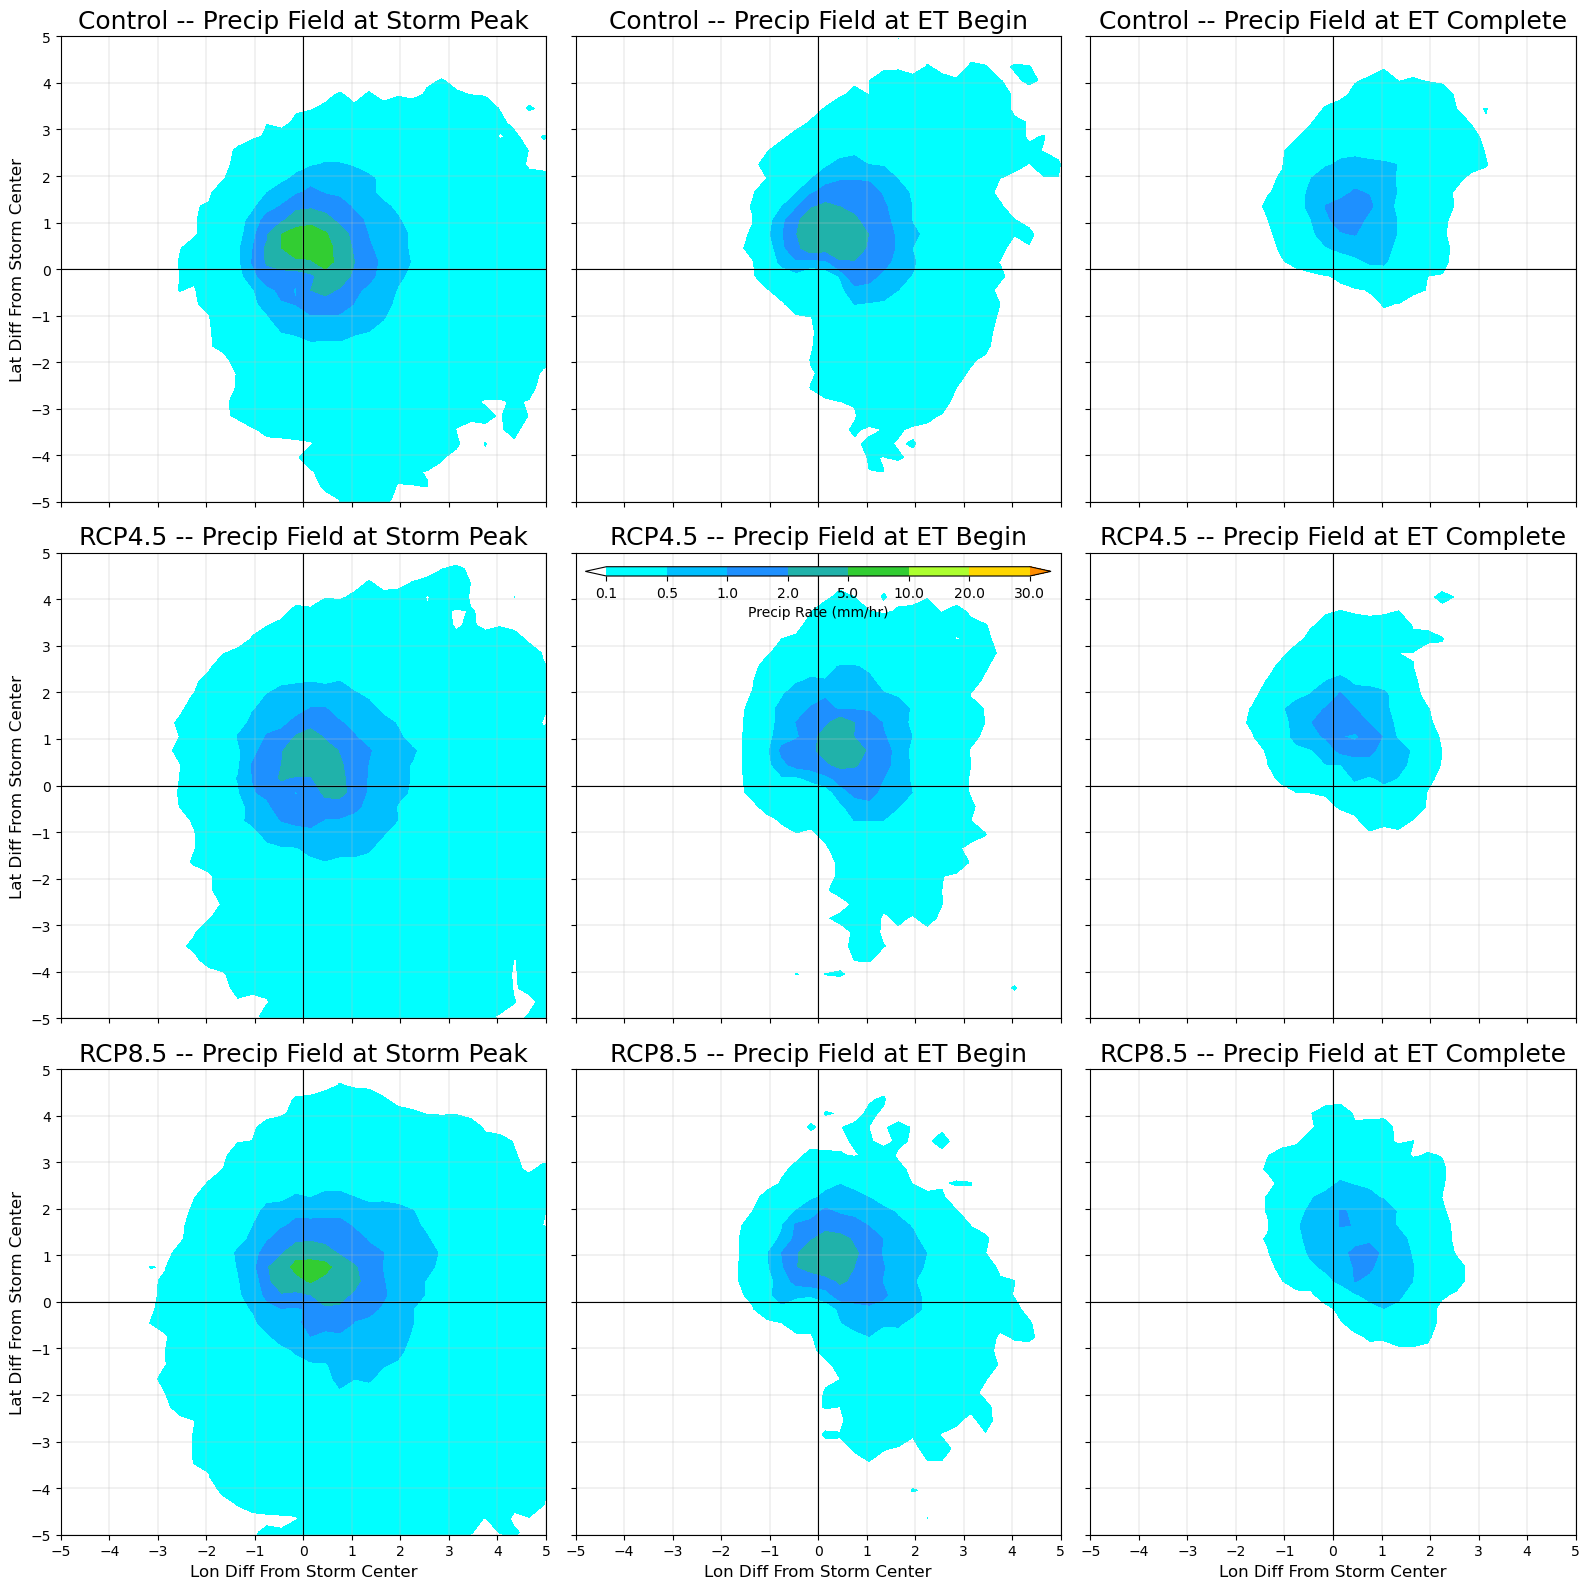

In [47]:
Precip_Snap_Plots([Control_Precip_Snap_Median, RCP45_Precip_Snap_Median, RCP85_Precip_Snap_Median], \
Control_A_Compo_nc, Time_Labels, Precip_Bounds, Precip_Colours, True, 'Precip_Snaps_Median.png')

In [48]:
# Define Colours and Bounds
Wind_Diff_Colours = ['darkgreen', 'limegreen', 'lawngreen', 'white', 'gold', 'darkorange', 'red']
Wind_Diff_Bounds = numpy.array([-5,-3,-1,1,3,5])
Precip_Diff_Colours = ['saddlebrown', 'darkorange', 'gold', 'yellow', 'white', \
'cyan', 'deepskyblue', 'dodgerblue', 'mediumblue']
Precip_Diff_Bounds = numpy.array([-4,-2,-1,-0.1,0.1,1,2,4])

In [49]:
# Create Function to Plot Contour Maps
def Contour_Map_Diff(Axis, i, j, Snap_1, Snap_2, x_Snap, y_Snap, Bounds, Colours, Model_1, Model_2, Time_Label, Var):
# Add Corrdinate Lines
    Axis.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    Axis.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Calculate Difference
    Snap_Diff = Snap_1 - Snap_2
# Plot Contour Map
    Axis.contourf(x_Snap, y_Snap, Snap_Diff, levels=Bounds, colors=Colours, extend='both')
# Formatting
    if Var == "Wind":
        Axis.set_xlim(-8,8)
        Axis.set_ylim(-8,8)
        Axis.set_xticks(Create_Bins(-8,8,2))
        Axis.set_yticks(Create_Bins(-8,8,2))
    elif Var == "Precip":
        Axis.set_xlim(-5,5)
        Axis.set_ylim(-5,5)
        Axis.set_xticks(Create_Bins(-5,5,1))
        Axis.set_yticks(Create_Bins(-5,5,1))
    if i == 2:
        Axis.set_xlabel('Lon Diff From Storm Center', fontsize=12)
    if j == 0:
        Axis.set_ylabel('Lat Diff From Storm Center', fontsize=12)
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Model_1 + (' - ') + Model_2 + (' -- Difference at ') + Time_Label)
    Axis.set_title(Title, fontsize=16)

In [50]:
# Plot Windspeed Snap Diff Plots
def Windspeed_Snap_Diff_Plots(Models_Wind_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Diff_Bounds, Diff_Colours, \
Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Var = "Wind"
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for j in range(3):
        Contour_Map(Axes[0][j], 0, j, Models_Wind_Snaps[0][j], x_Snap, y_Snap, Bounds, Colours, \
        Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[1][j], 1, j, Models_Wind_Snaps[1][j], Models_Wind_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[1], Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[2][j], 2, j, Models_Wind_Snaps[2][j], Models_Wind_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[2], Models[0], Time_Labels[j], Var)
#
# Colour Bar For Control
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeed", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[0][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[0][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeed (m/s)', shrink=0.7)
#
# Colour Bar For Difference Plots
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeed Diff", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeed Difference (m/s)', shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [51]:
# Plot Precip Snap Diff Plots
def Precip_Snap_Diff_Plots(Models_Wind_Snaps, Compo_nc, Time_Labels, Bounds, Colours, Diff_Bounds, Diff_Colours, \
Savefig, Figname):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
    Axes = Fig.subplots(3,3, sharex=True, sharey=True)
    Var = "Precip"
    Models = ["Control", "RCP4.5", "RCP8.5"]
#
# Plotting
    for j in range(3):
        Contour_Map(Axes[0][j], 0, j, Models_Wind_Snaps[0][j], x_Snap, y_Snap, Bounds, Colours, \
        Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[1][j], 1, j, Models_Wind_Snaps[1][j], Models_Wind_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[1], Models[0], Time_Labels[j], Var)
        Contour_Map_Diff(Axes[2][j], 2, j, Models_Wind_Snaps[2][j], Models_Wind_Snaps[0][j], \
        x_Snap, y_Snap, Diff_Bounds, Diff_Colours, Models[2], Models[0], Time_Labels[j], Var)
#
# Colour Bar For Control
    C_Map = mcolors.LinearSegmentedColormap.from_list("Precip Rate", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axes[0][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[0][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='Precip Rate (mm/hr)', shrink=0.7)
#
# Colour Bar For Difference Plots
    C_Map = mcolors.LinearSegmentedColormap.from_list("Precip Rate Diff", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axes[1][1].inset_axes([0.02, 0.95, 0.96, 0.02], transform=Axes[1][1].transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='Precip Rate Difference (mm/hr)', shrink=0.7)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [52]:
# Mean Snapshot Diff Plots

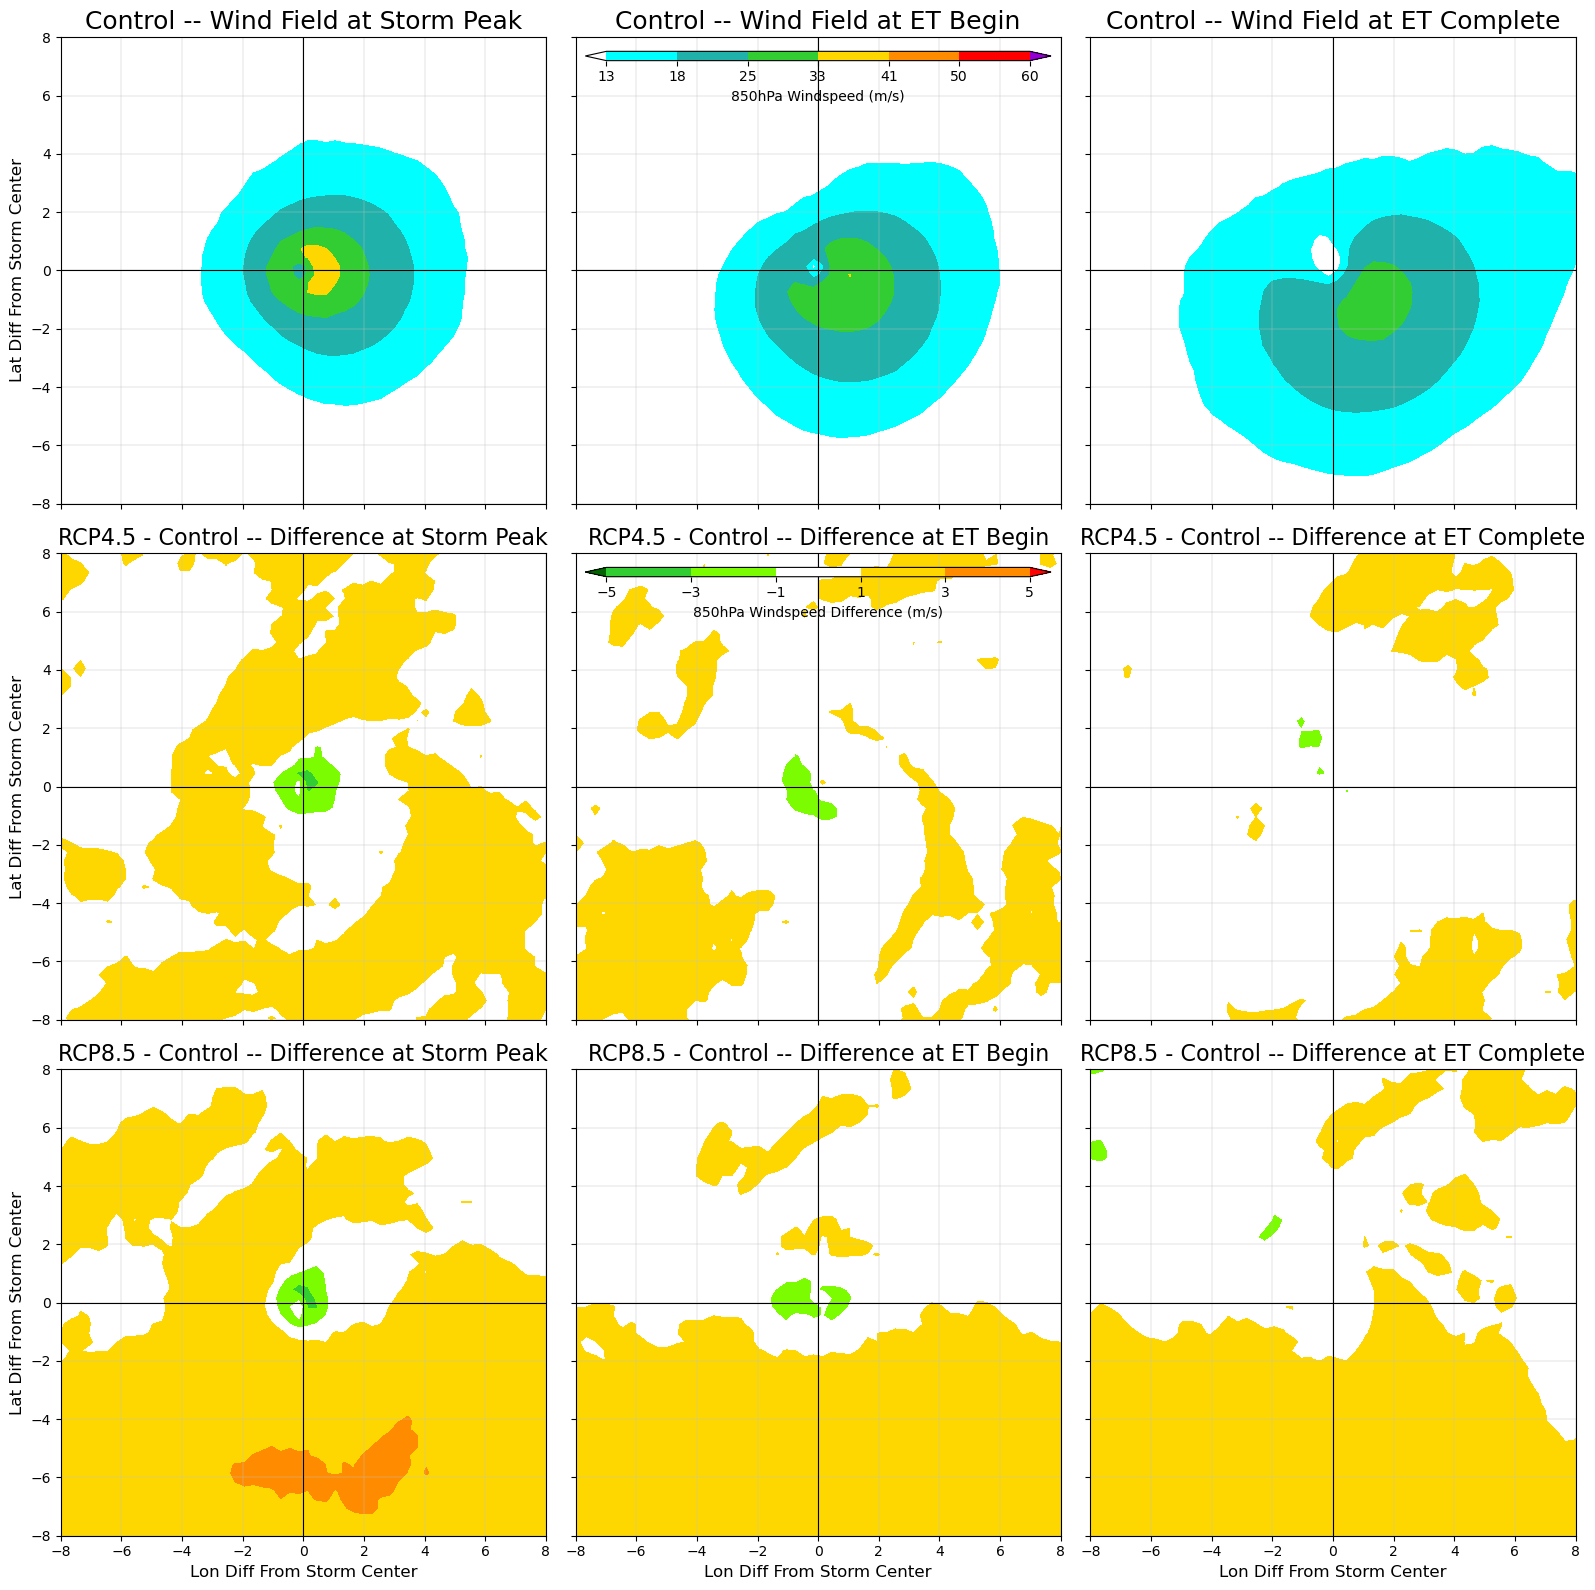

In [53]:
Windspeed_Snap_Diff_Plots([Control_Wind_Snap_Mean, RCP45_Wind_Snap_Mean, RCP85_Wind_Snap_Mean], \
Control_A_Compo_nc, Time_Labels, Windspeed_Bounds, Windspeed_Colours, Wind_Diff_Bounds, Wind_Diff_Colours, \
True, 'Wind_Snaps_Diff_Mean.png')

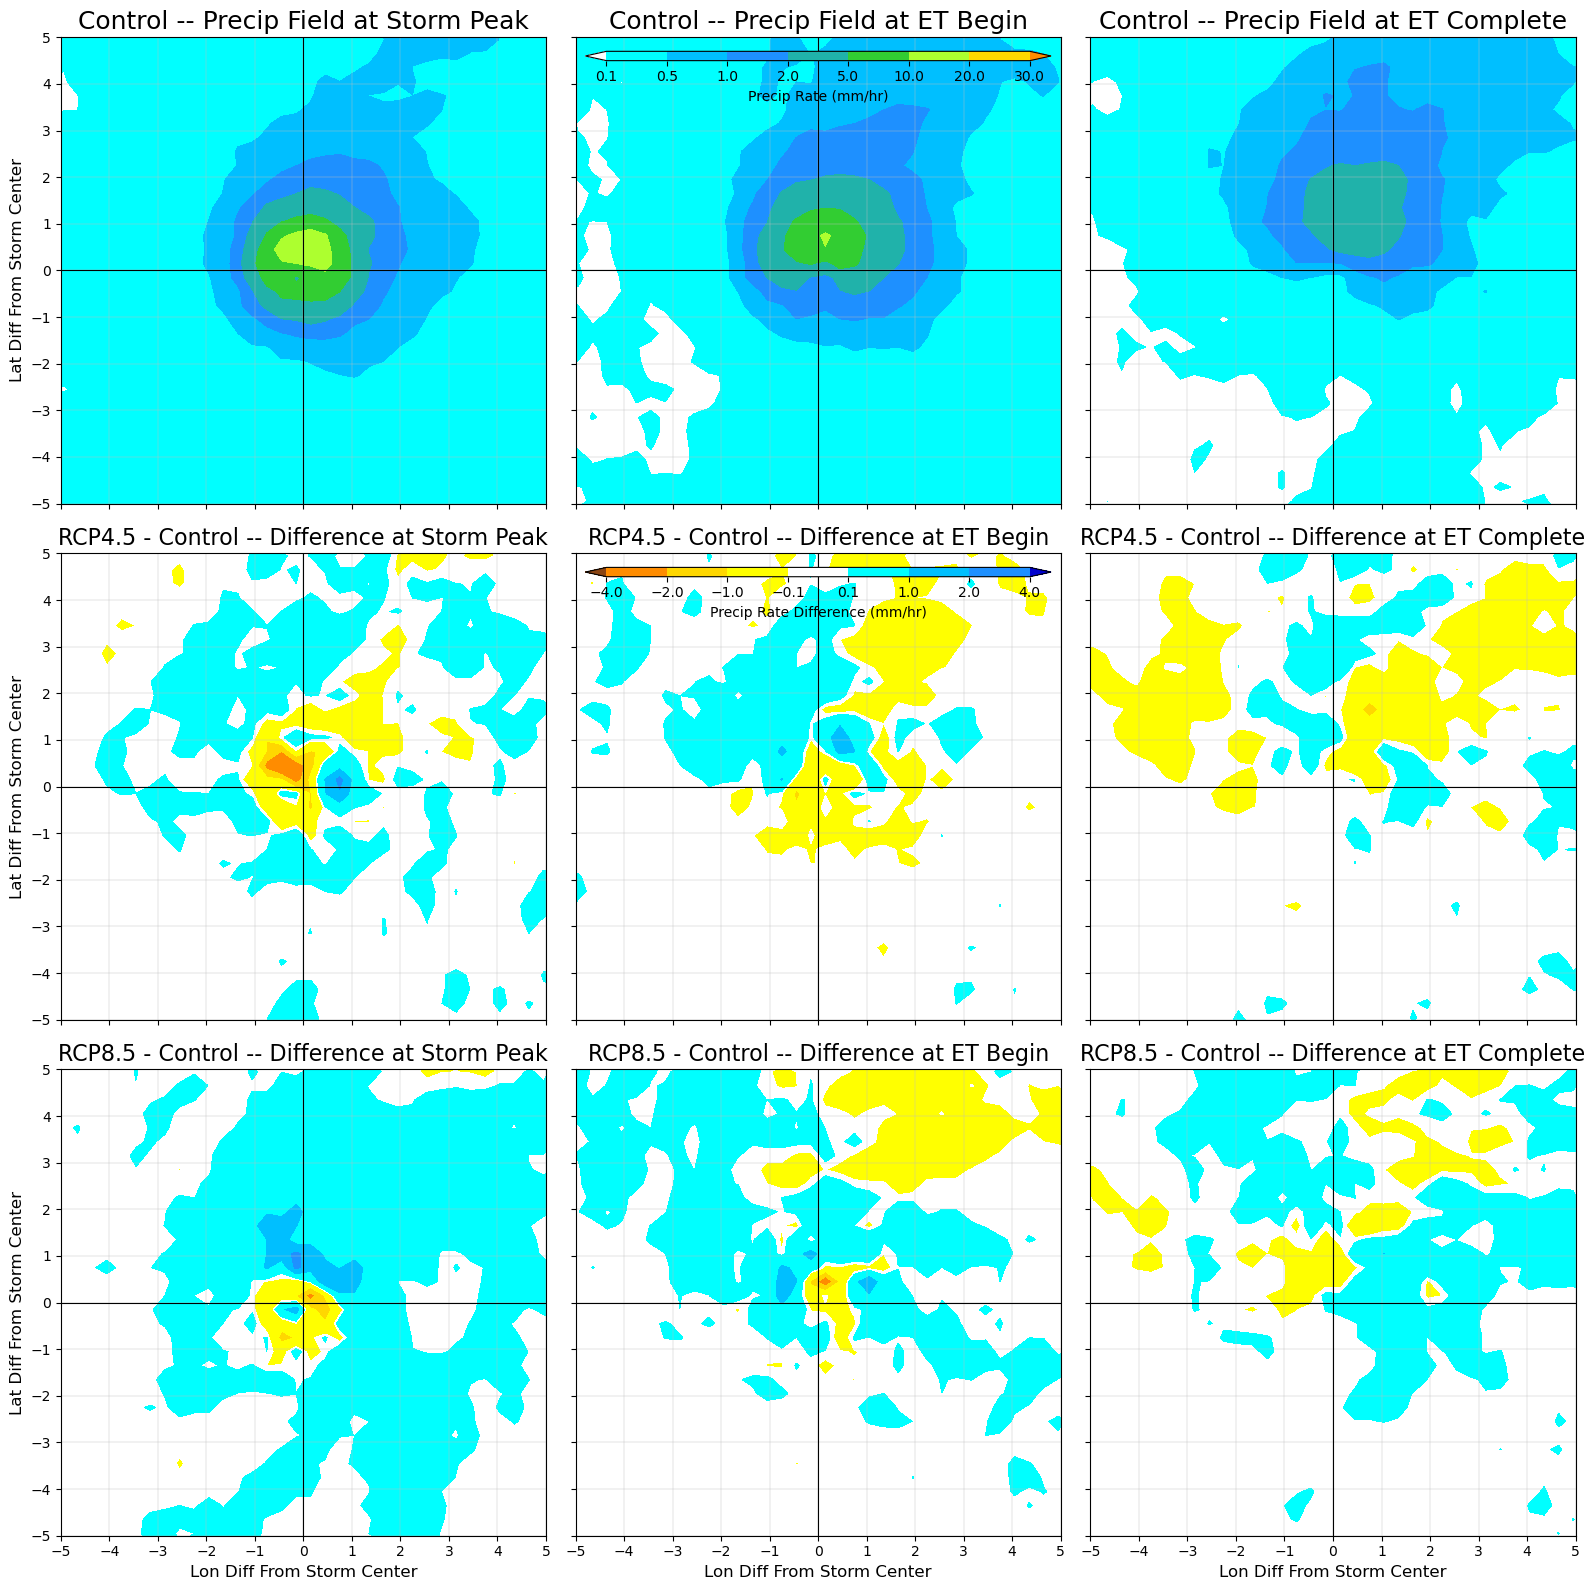

In [54]:
Precip_Snap_Diff_Plots([Control_Precip_Snap_Mean, RCP45_Precip_Snap_Mean, RCP85_Precip_Snap_Mean], \
Control_A_Compo_nc, Time_Labels, Precip_Bounds, Precip_Colours, Precip_Diff_Bounds, Precip_Diff_Colours, \
True, 'Precip_Snaps_Diff_Mean.png')

In [55]:
# Median Snapshot Diff Plots

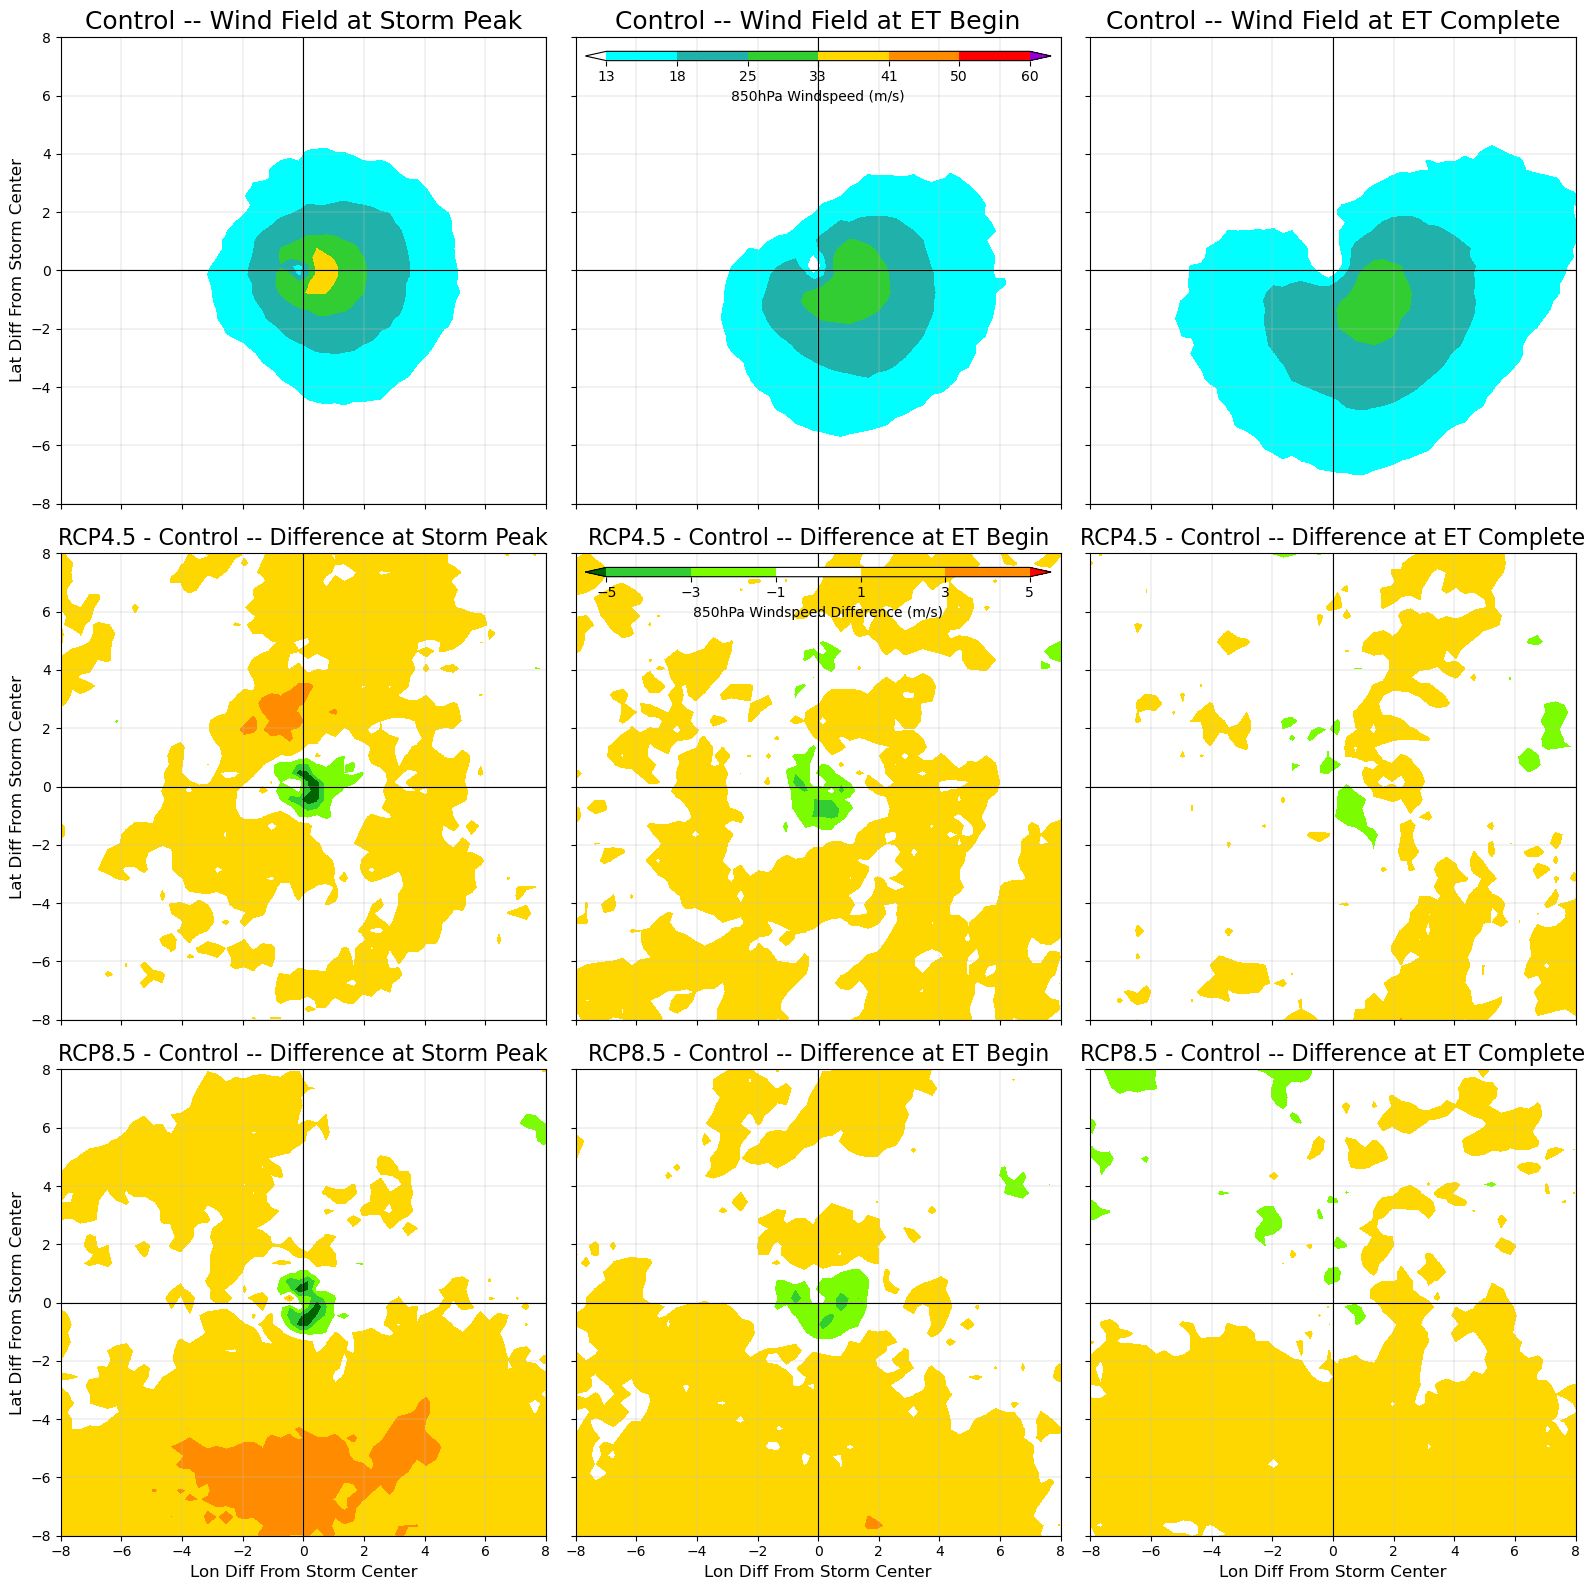

In [56]:
Windspeed_Snap_Diff_Plots([Control_Wind_Snap_Median, RCP45_Wind_Snap_Median, RCP85_Wind_Snap_Median], \
Control_A_Compo_nc, Time_Labels, Windspeed_Bounds, Windspeed_Colours, Wind_Diff_Bounds, Wind_Diff_Colours, \
True, 'Wind_Snaps_Diff_Median.png')

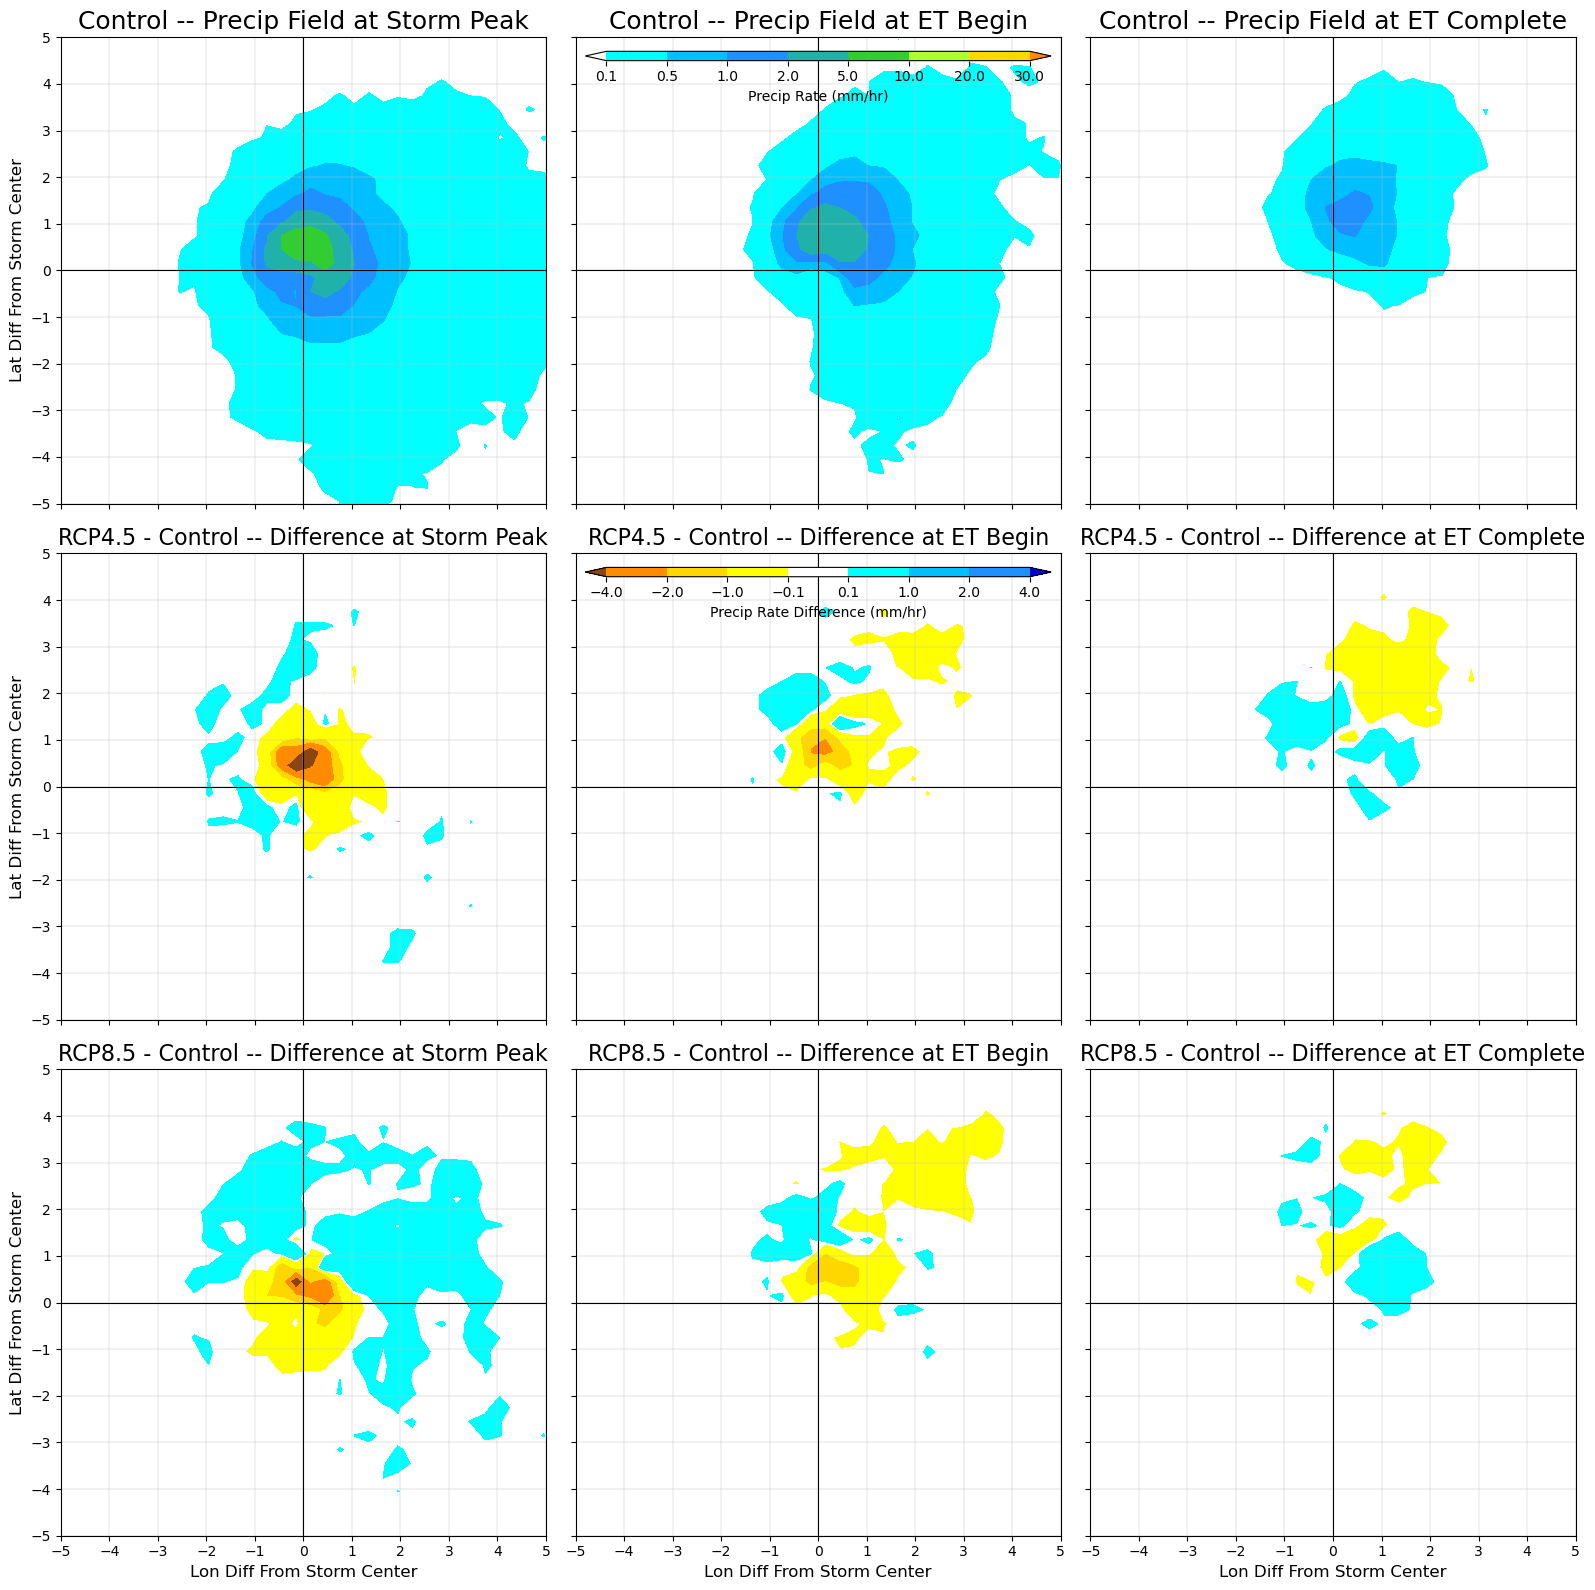

In [57]:
Precip_Snap_Diff_Plots([Control_Precip_Snap_Median, RCP45_Precip_Snap_Median, RCP85_Precip_Snap_Median], \
Control_A_Compo_nc, Time_Labels, Precip_Bounds, Precip_Colours, Precip_Diff_Bounds, Precip_Diff_Colours, \
True, 'Precip_Snaps_Diff_Median.png')